# Photometric Color correction

## Import

In [1]:
# Import some generally useful packages

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
from scipy import interpolate

In [3]:
# Import the primary photometry classes from rubin_sim.photUtils

import rubin_sim.photUtils.Bandpass as Bandpass
import rubin_sim.photUtils.Sed as Sed

In [4]:
from libradtranpy import  libsimulateVisible

libradtranpath= /sps/lsst/groups/auxtel/softs/utils/External/libRadtran/


In [5]:
import warnings
warnings.filterwarnings("ignore")

## Configuration

In [6]:
path_throughput="/sps/lsst/groups/auxtel/softs/github/desc/throughputs/baseline"

In [7]:
atm_std_filename = "atmos_std.dat"

In [8]:
filter_filenames = ["total_u.dat","total_g.dat","total_r.dat","total_i.dat","total_z.dat","total_y.dat" ]
filter_tagnames = ["u","g","r","i","z","y"]
filter_color = ["b","g","r","orange","grey","k"]
NFILT=len(filter_filenames)

In [9]:
WLMIN=300.
WLMAX=1100.
WLBIN=1.
NWLBIN=int((WLMAX-WLMIN)/WLBIN)
WL=np.linspace(WLMIN,WLMAX,NWLBIN)

## Initialisation

In [10]:
df_std=pd.DataFrame()

In [11]:
df_std["wl"] = WL

### Standard atmosphere

In [12]:
fullfilename=os.path.join(path_throughput,atm_std_filename)

In [13]:
arr= np.loadtxt(fullfilename)

In [14]:
f = interpolate.interp1d(x=arr[:,0], y=arr[:,1],fill_value="extrapolate")

In [15]:
atm_std=f(WL)

In [16]:
df_std["atm"] = atm_std

### Total filters

In [17]:
FILTERWL = np.zeros((NWLBIN,3))
for index,filename in enumerate(filter_filenames):
    fullfilename=os.path.join(path_throughput,filename)
    arr= np.loadtxt(fullfilename)
    ff = interpolate.interp1d(x=arr[:,0], y=arr[:,1],fill_value="extrapolate")
    throughput1=ff(WL)
    throughput2=throughput1/atm_std
    tag1="tot_"+filter_tagnames[index]
    tag2="inst_"+filter_tagnames[index]
    df_std[tag1]= throughput1
    df_std[tag2]= throughput2
    indexes=np.where(throughput2>0.05)[0]
    FILTERWL[index,0]=WL[indexes.min()] 
    FILTERWL[index,1]=WL[indexes.max()] 
    lambdab=np.trapz(throughput2,WL)/np.trapz(throughput2/WL,WL)
    FILTERWL[index,2]=lambdab

In [18]:
FILTERWL

array([[324.03003755, 402.12765957, 363.59690349],
       [392.11514393, 561.32665832, 473.54069923],
       [542.3028786 , 700.50062578, 619.49926767],
       ...,
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ]])

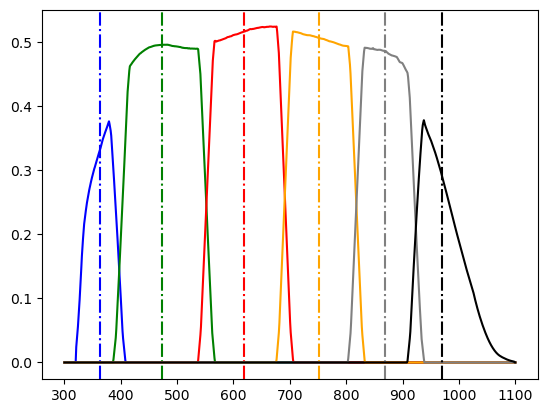

In [19]:
for index in range(NFILT):
    tag="inst_"+filter_tagnames[index]
    plt.plot(WL,df_std[tag].values,color=filter_color[index]) 
    plt.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    #plt.axvline(FILTERWL[index,0],color=filter_color[index],linestyle=":")

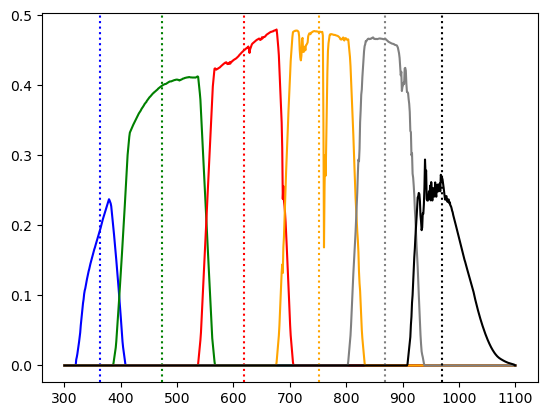

In [20]:
for index in range(NFILT):
    tag="tot_"+filter_tagnames[index]
    plt.plot(WL,df_std[tag].values,color=filter_color[index]) 
    plt.axvline(FILTERWL[index,2],color=filter_color[index],linestyle=":")

## Functions

In [21]:
def fII0(wl,s):
    return np.trapz(s/wl,wl)

In [22]:
def fII1(wl,s,wlb):
    return np.trapz(s*(wl-wlb)/wl,wl)

In [23]:
def fII2(wl,s,wlb):
    return np.trapz(s*(wl-wlb)**2/wl,wl)

In [24]:
def fII10(wl,s,wlb):
    return fII1(wl,s,wlb)/fII0(wl,s)

In [25]:
def fII20(wl,s,wlb):
    return fII2(wl,s,wlb)/fII0(wl,s)

In [26]:
def CalculateIIntegrals(df_S,wlb):
    """
    """
    II0 = np.zeros(NFILT)
    II1 = np.zeros(NFILT)
    II2 = np.zeros(NFILT)
    II10 = np.zeros(NFILT)
    II20 = np.zeros(NFILT)
    
    for index in range(NFILT):
        tag="tot_"+filter_tagnames[index]
        wl=df_S["wl"].values
        S=df_S[tag].values
        II0[index] = fII0(wl,S)
        II1[index] = fII1(wl,S,wlb[index])
        II2[index] = fII2(wl,S,wlb[index])
        II10[index] = fII10(wl,S,wlb[index])
        II20[index] = fII20(wl,S,wlb[index])
        
    df_II = pd.DataFrame()
    df_II["II0"]=II0
    df_II["II1"]=II1
    df_II["II2"]=II2
    df_II["II10"]=II10
    df_II["II20"]=II20    
    return df_II
    

# Calculate Integrals for Standard atmosphere

In [27]:
df_IIstd = CalculateIIntegrals(df_std,FILTERWL[:,2])

In [28]:
df_IIstd 

,II0,II1,II2,II10,II20
0,0.033338,0.079194,12.612354,2.375463,378.312338
1,0.121926,0.305935,230.105550,2.509184,1887.257382
2,0.100710,0.096977,167.700718,0.962933,1665.181331
3,0.077127,0.025279,109.332320,0.327765,1417.570239
4,0.053724,-0.024968,50.296178,-0.464738,936.189562
5,0.025932,0.089871,32.480106,3.465616,1252.500277


# Airmass effect

In [29]:
all_am = np.linspace(1,3,15)
pwv= 3
aer= 0.04
oz = 300

In [30]:
all_am

array([1.        , 1.14285714, 1.28571429, 1.42857143, 1.57142857,
       1.71428571, 1.85714286, 2.        , 2.14285714, 2.28571429,
       2.42857143, 2.57142857, 2.71428571, 2.85714286, 3.        ])

In [31]:
all_df_obs = []


for index,am in enumerate(all_am):
    path,thefile = libsimulateVisible.ProcessSimulationaer(am,pwv,oz,aer,0,prof_str='us',proc_str='sa',cloudext=0.0, FLAG_VERBOSE=False)
    data = np.loadtxt(os.path.join(path,thefile))
    f = interpolate.interp1d(x=data[:,0], y=data[:,1],fill_value="extrapolate")
    atm=f(WL)
    
    
    df_obs=pd.DataFrame()
    df_obs["wl"] = WL
    df_obs["atm"] = atm
    
    
    for findex in range(NFILT):
        tag1="tot_"+filter_tagnames[findex]
        tag2="inst_"+filter_tagnames[findex]
    
        df_obs[tag1]= df_std[tag2].values*atm
        df_obs[tag2]= df_std[tag2].values
    
    all_df_obs.append(df_obs)
    

******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from 

In [33]:
all_df_obs[1]

,wl,atm,tot_u,inst_u,tot_g,inst_g,tot_r,inst_r,tot_i,inst_i,tot_z,inst_z,tot_y,inst_y
0,300.000000,0.012318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,301.001252,0.019047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,302.002503,0.027382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,303.003755,0.042260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,304.005006,0.049705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,1095.994994,0.970566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001660,0.001711
796,1096.996245,0.970559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001475,0.001520
797,1097.997497,0.966939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001286,0.001330
798,1098.998748,0.952696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000017,0.000017
